In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model 
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import huber_loss
from models.model import DARKNET19_ARCHITECTURE, INPUT_SIZE, build_model
from keras.metrics import MeanIoU
from keras.utils import np_utils
import albumentations
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import random
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

d:\Anaconda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

print(tf.config.list_physical_devices('GPU'))

WIDTH = 448
HEIGHT = 448 
BATCH_SIZE = 8
TEST_SPLIT = 0.2
LEARNING_RATE = 5e-3
EPOCHS = 100

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data

In [4]:
# with open("bboxes.json", "r") as f:
#     data = json.load(f)

# data = {}

# for i in os.listdir("labels/"):
#     with open(f"labels/{i}") as f:
#         temp = []
#         for line in f:
#             temp.append(line.split()[4:8])
#         if(len(temp) == 4):
#             labels = temp
#         else:
#             labels = []
        
#         if(labels != []):
#             i = i.split(".")[0] + ".jpg"
#             data[i] = {}

#             for _ in range(2):
#                 labels.pop(0)

#             data[i] = [int(labels[0][0]), int(labels[0][1]), int(labels[0][2]), int(labels[0][3])]


In [5]:
data = {}

dataset_path = "D:\multiview_hand_pose_dataset_release"
for dir in os.listdir(dataset_path):
    for i in range(100):
        for j in range(4):
            bbox = []
            try:
                with open(f"{dataset_path}\{dir}\{i}_bbox_{j+1}.txt", "r") as f:
                    for line in f:
                        bbox.append(int(line.split(" ")[1].strip("\n")))
                bbox[0], bbox[1] = bbox[1], bbox[0]
                bbox[2], bbox[3] = bbox[3], bbox[2]
                data[f"{dir}\{i}_webcam_{j+1}.jpg"] = bbox
            except: 
                continue

print(len(data))

# for file in data:
#     bbox = data[file]

#     image = cv2.imread(f"{dataset_path}\{file}")
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255,0,0), 2)
#     plt.imshow(image)
#     plt.show()

8400


In [6]:
# Get data and transform left hand labels to 0 and right hand labels to 1
df = pd.DataFrame({"filename": [], "bbox": []})
for filename in data:
    df.loc[len(df)] = [filename, data[filename]]
df = df.sample(frac=1)

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=TEST_SPLIT, shuffle=False)

train_images, train_bboxes = train["filename"].to_numpy(), train["bbox"].to_numpy()
test_images, test_bboxes = test["filename"].to_numpy(), test["bbox"].to_numpy()

d:\Anaconda\lib\site-packages\pandas\core\dtypes\cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


## 2. Data Preprocessing
### 2.1 Resizing & Normalisation

In [7]:
def read_image(path, bbox):

    filename = path.decode("utf-8")
    path = f"{dataset_path}\{filename}"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if(bbox[0] > image.shape[1]):
        bbox[0] = image.shape[1]
    if(bbox[2] > image.shape[1]):
        bbox[2] = image.shape[1]

    if(bbox[1] > image.shape[0]):
        bbox[1] = image.shape[0]
    if(bbox[3] > image.shape[0]):
        bbox[3] = image.shape[0]

    for i in range(4):
        if(bbox[i] < 0):
            bbox[i] = 0
        
    # cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255,0,0), 1)
    # plt.imshow(image)
    # plt.show()

    transform = albumentations.Compose(
        [albumentations.Resize(height=HEIGHT, width=WIDTH, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='pascal_voc'))

    transformed = transform(image=image, bboxes=[np.concatenate([bbox,[0]])])
    image, bbox = transformed["image"], transformed["bboxes"][0]



    norm_image = tf.cast(image, tf.float32) / 255.

    x1, y1, x2, y2 = bbox[0]/WIDTH, bbox[1]/HEIGHT, bbox[2]/WIDTH, bbox[3]/HEIGHT
    norm_bbox = np.array([x1, y1, x2, y2], dtype=np.float32)


    return norm_image, norm_bbox


### 2.2 Transforming data to Tensors

In [8]:
def parse(image, bbox):
    image, bbox = tf.numpy_function(read_image, [image, bbox], [tf.float32, tf.float32])
    image.set_shape((WIDTH, HEIGHT, 3))
    bbox.set_shape((4))
    return image, bbox

# print(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, list(train_bboxes)))
train_dataset = train_dataset.map(parse).batch(5)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, list(test_bboxes)))
test_dataset = test_dataset.map(parse).batch(5)

# for X, bbox  in train_dataset:
#     print(X.shape, bbox.shape)




def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)



def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.numpy_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou




## The CNN Model

In [9]:
model = build_model(DARKNET19_ARCHITECTURE, INPUT_SIZE)
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE), loss="huber_loss", metrics=[IoU, "accuracy"])

# checkpoint_path = "/home/mushi/hand-gesture-project/models/model.hdf5"

callbacks = [
    ModelCheckpoint("models\model3.hdf5", verbose=1, save_weights_only=True, monitor='val_loss', save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

print(train_dataset)
model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks=callbacks)

<BatchDataset element_spec=(TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Epoch 1/100
1344/1344 [==============================] - ETA: 0s - loss: 52.0819 - IoU: 0.4197 - accuracy: 0.5256
Epoch 1: saving model to models\model3.hdf5
1344/1344 [==============================] - 355s 258ms/step - loss: 52.0819 - IoU: 0.4197 - accuracy: 0.5256 - val_loss: 45.3877 - val_IoU: 0.4457 - val_accuracy: 0.5821 - lr: 0.0050
Epoch 2/100
1344/1344 [==============================] - ETA: 0s - loss: 39.8025 - IoU: 0.5190 - accuracy: 0.6923
Epoch 2: saving model to models\model3.hdf5
1344/1344 [==============================] - 336s 250ms/step - loss: 39.8025 - IoU: 0.5190 - accuracy: 0.6923 - val_loss: 34.6875 - val_IoU: 0.5010 - val_accuracy: 0.6804 - lr: 0.0050
Epoch 3/100
1344/1344 [==============================] - ETA: 0s - loss: 30.4192 - IoU: 0.5873 - accuracy: 0.7292
Epoch 3: saving model to models\model3.hdf5
134

KeyboardInterrupt: 

## 3. Evaluation

1/1 [==============================] - 0s 151ms/step


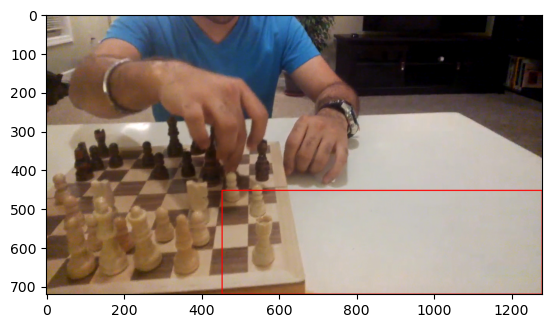

1/1 [==============================] - 0s 15ms/step


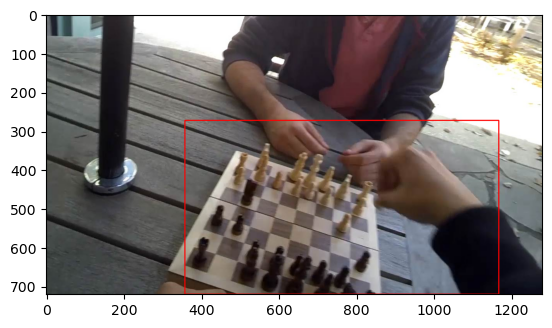

1/1 [==============================] - 0s 15ms/step


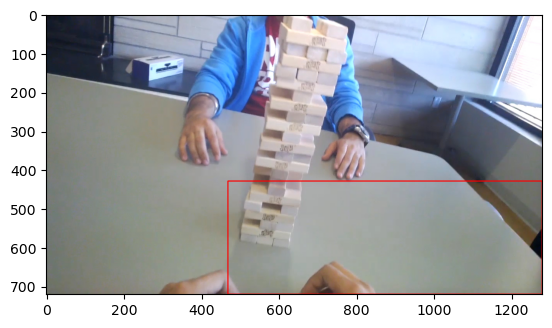

1/1 [==============================] - 0s 15ms/step


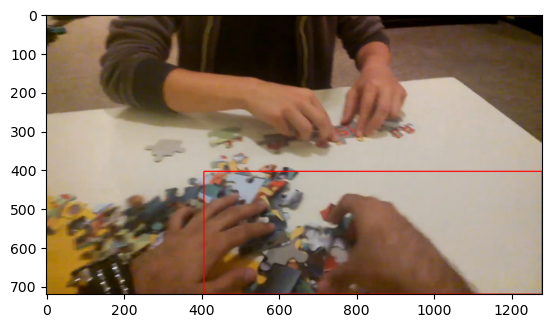

1/1 [==============================] - 0s 15ms/step


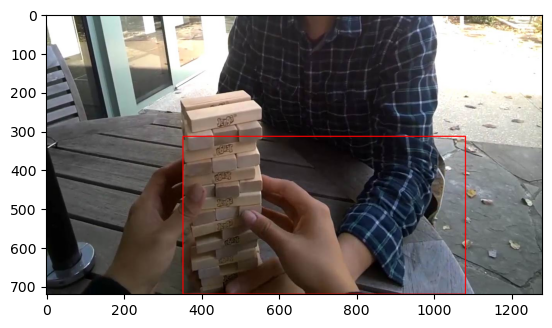

1/1 [==============================] - 0s 15ms/step


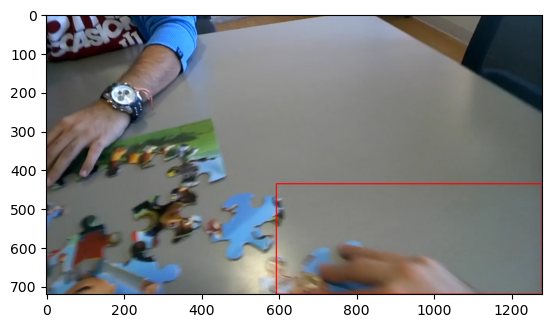

1/1 [==============================] - 0s 15ms/step


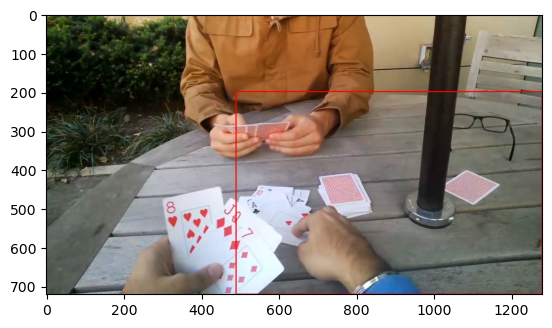

1/1 [==============================] - 0s 15ms/step


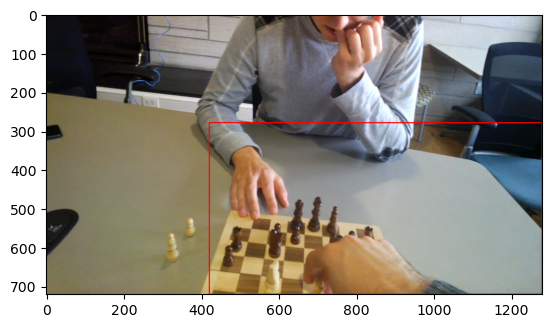

1/1 [==============================] - 0s 15ms/step


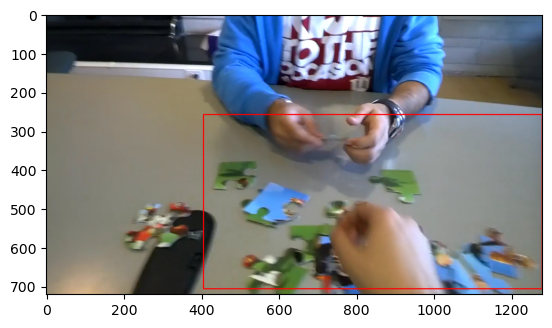

1/1 [==============================] - 0s 16ms/step


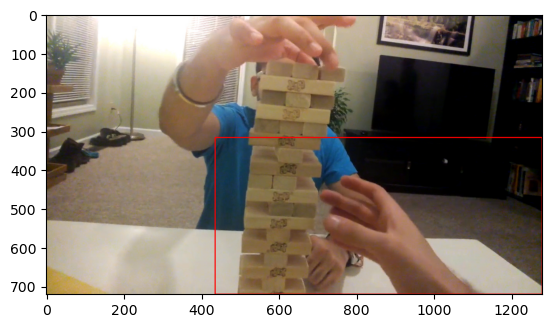

In [31]:
model = build_model(DARKNET19_ARCHITECTURE, INPUT_SIZE)
model.load_weights("models\model3.hdf5")
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE), loss="huber_loss", metrics=[IoU, "accuracy"])
# model.evaluate(test_dataset)

import random 

# image = cv2.imread(f"{dataset_path}\data_4\\564_webcam_3.jpg")
for i in range(10):
    name = random.choice(os.listdir("images"))
    image = cv2.imread(f"images\{name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x = cv2.resize(image, (WIDTH, HEIGHT))
    x = tf.cast(x, tf.float32) / 255.
    x = np.expand_dims(x, axis=0)

    pred_bbox = model.predict(x)
    pred_bbox = pred_bbox[0]
    # print( pred_bbox)

    pred_x1 = int(pred_bbox[0] * image.shape[1])
    pred_y1 = int(pred_bbox[1] * image.shape[0])
    pred_x2 = int(pred_bbox[2] * image.shape[1])
    pred_y2 = int(pred_bbox[3] * image.shape[0])

    cv2.rectangle(image, (pred_x1, pred_y1, pred_x2, pred_y2), (255,0,0), 2)

    plt.imshow(image)
    plt.show()
